In [1]:
import pandas as pd
import numpy as np
import string
import re
import pickle

import contractions

import unicodedata

import copy

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Embedding, Dense
import nltk

from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

from keras.callbacks import ModelCheckpoint, EarlyStopping


In [2]:
df= pd.read_csv('C:/Users/sidac/Downloads/Hindi_English_Truncated_Corpus.csv', encoding='utf-8')

In [3]:
df=df[df['source']=='ted']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39881 entries, 0 to 127606
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            39881 non-null  object
 1   english_sentence  39881 non-null  object
 2   hindi_sentence    39881 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


# Preprocessing

In [5]:
def expand_contractions(text):
    return contractions.fix(text)

In [6]:
def preprocess_data(data):
    remove_special= set(string.punctuation)
    data['english_sentence']=data['english_sentence'].apply(lambda x: x.lower())
    data['english_sentence']=data['english_sentence'].apply(expand_contractions)
    data['english_sentence']=data['english_sentence'].apply(lambda x: re.sub(r'[^a-zA-Z ]+', "", x))
    data['english_sentence']=data['english_sentence'].apply(lambda x: x.strip())
    data['english_sentence']=data['english_sentence'].apply(lambda x: re.sub(" +", " ", x))



    data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: re.sub("'", "", x))
    data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: re.sub("।", "", x))
    data['hindi_sentence']=data['hindi_sentence'].str.replace("\d+", "", regex=True)
    data['hindi_sentence']=data['hindi_sentence'].str.replace(r'[a-zA-Z]', '', regex=True)
    data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: x.strip())
    data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))
    data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in remove_special))
    data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: unicodedata.normalize('NFKC', x))


    return data

In [7]:
df = preprocess_data(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39881 entries, 0 to 127606
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            39881 non-null  object
 1   english_sentence  39881 non-null  object
 2   hindi_sentence    39881 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


## Test-Train Split

In [9]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=31)
df_val, df_test = train_test_split(df_temp, test_size=0.33, random_state=42)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27916 entries, 44855 to 85471
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            27916 non-null  object
 1   english_sentence  27916 non-null  object
 2   hindi_sentence    27916 non-null  object
dtypes: object(3)
memory usage: 872.4+ KB


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3949 entries, 27094 to 71294
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            3949 non-null   object
 1   english_sentence  3949 non-null   object
 2   hindi_sentence    3949 non-null   object
dtypes: object(3)
memory usage: 123.4+ KB


In [12]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8016 entries, 38552 to 49706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            8016 non-null   object
 1   english_sentence  8016 non-null   object
 2   hindi_sentence    8016 non-null   object
dtypes: object(3)
memory usage: 250.5+ KB


In [13]:
hin_val_copy=df_val['hindi_sentence']
hin_train_copy=df_train['hindi_sentence']
hin_test_copy=df_test['hindi_sentence']

In [14]:
df_train

source                                   english_sentence  \
44855     ted  thankfully baby was out mother and child survived   
23094     ted             and that is a real fantastic bulls eye   
55944     ted  and watch them five times because they are so ...   
7125      ted            maybe how about i take my digital world   
75634     ted  for a long time india was this country of poverty   
...       ...                                                ...   
107982    ted        your knowledge is limited health is limited   
11984     ted  the complexity of the network is actually the ...   
48120     ted                        so what makes people notice   
88317     ted  from everything from the television to adverti...   
85471     ted              and as the last ted prize winner said   

                                           hindi_sentence  
44855   शुक्र है शिशु बहार आ गया जच्चाबच्चा दोनों जीवि...  
23094                              यह एक विलक्षण दृश्य है  
55944   और उसे पांच बार देखेंगे क्यूंकि कि वो सब कितने...  
7125                     “क्यों न मैं डिजिट्ल दुनिया लेकर  
75634               एक लम्बे समय तक भारत अभावों का देश था  
...                                                   ...  
107982             तुम्हारा ज्ञान सीमित हैस्वस्थ सीमित है  
11984                  नेटवर्क की जड़िलता दरअसल गुनिया है  
48120           तो ऐसा क्या हैं जिससे लोग को पता चलता हैं  
88317                           टेलीविजन से लेकर विज्ञापन  
85471          और जैसा कि पिछले टेड प्राइज़ विजेता ने कहा  

[27916 rows x 3 columns]

In [15]:
df_train[0:5]

source                                   english_sentence  \
44855    ted  thankfully baby was out mother and child survived   
23094    ted             and that is a real fantastic bulls eye   
55944    ted  and watch them five times because they are so ...   
7125     ted            maybe how about i take my digital world   
75634    ted  for a long time india was this country of poverty   

                                          hindi_sentence  
44855  शुक्र है शिशु बहार आ गया जच्चाबच्चा दोनों जीवि...  
23094                             यह एक विलक्षण दृश्य है  
55944  और उसे पांच बार देखेंगे क्यूंकि कि वो सब कितने...  
7125                    “क्यों न मैं डिजिट्ल दुनिया लेकर  
75634              एक लम्बे समय तक भारत अभावों का देश था

In [16]:
df_test

source                                   english_sentence  \
27094     ted                                and that is tragedy   
49436     ted                               before they get made   
58528     ted  now a lot of you are probably familiar with de...   
21747     ted           and that is four percent of the universe   
109262    ted                     it was designed some years ago   
...       ...                                                ...   
32467     ted          and i am thinking no this is not possible   
92496     ted    and this is very similar to a q and you example   
110369    ted                        they tell us to have a bath   
123879    ted                   what was he thinking about lunch   
71294     ted   so that i could grow it back as my father had it   

                                           hindi_sentence  
27094                                    और वह हैदुर्घटना  
49436                                 इससे पहले कि वह बने  
58528       आप में से बहुत शायद देब रॉय के साथ परिचित हैं  
21747      और उसकी मात्रा ब्रह्माण्ड मे सिर्फ प्रतिशत हैं  
109262                        यह लगभग साल पहले बनाई गई थी  
...                                                   ...  
32467             और मैने सोचा नहीं ये तो हो ही नहीं सकता  
92496              और यह बहुत कुछ एक और के उदाहरण जैसा है  
110369                       वो हमे स्नान करने को कहते है  
123879               वो किस विषय में सोचा करते होंगे खाना  
71294   ताकि मैं अपने पिताजी के बालो के समान उन्हे वाप...  

[3949 rows x 3 columns]

In [17]:
df_test[0:5]

source                                   english_sentence  \
27094     ted                                and that is tragedy   
49436     ted                               before they get made   
58528     ted  now a lot of you are probably familiar with de...   
21747     ted           and that is four percent of the universe   
109262    ted                     it was designed some years ago   

                                        hindi_sentence  
27094                                 और वह हैदुर्घटना  
49436                              इससे पहले कि वह बने  
58528    आप में से बहुत शायद देब रॉय के साथ परिचित हैं  
21747   और उसकी मात्रा ब्रह्माण्ड मे सिर्फ प्रतिशत हैं  
109262                     यह लगभग साल पहले बनाई गई थी

In [18]:
df_val

source                                   english_sentence  \
38552     ted                             i have spent my career   
125781    ted                                        is mistaken   
35312     ted  it rises up from passive torsion to active tor...   
24426     ted                and when i saw the street on the th   
62910     ted                 that behind most of us who succeed   
...       ...                                                ...   
50478     ted                                   as i have worked   
21495     ted              by pinning down meanings of their own   
123416    ted  but to cope with the circumstances of previous...   
51706     ted            and i could just imagine the committees   
49706     ted                                and we use the gear   

                                           hindi_sentence  
38552                        मैं अपने कैरियर खर्च किया है  
125781                                             गलत है  
35312   यह निष्क्रिय मरोड़ से सक्रिय मरोड़ करने के लिए...  
24426              और जब मैंने को लोगों पर सड़कों पर देखा  
62910                  कि हम में से ज्यादातर लोग सफल पीछे  
...                                                   ...  
50478                                    मैने काम किया है  
21495               इनकी अपने स्वार्थानुसार व्याख्या करके  
123416  लेकिन वह पिछले सदियों की परिस्थितियों से निपटन...  
51706        और मैं अभी ये कल्पना कर सकता हूँ कि संस्थाएं  
49706                        और हम गियर का उपयोग करते हैं  

[8016 rows x 3 columns]

In [19]:
df_val[0:5]

source                                   english_sentence  \
38552     ted                             i have spent my career   
125781    ted                                        is mistaken   
35312     ted  it rises up from passive torsion to active tor...   
24426     ted                and when i saw the street on the th   
62910     ted                 that behind most of us who succeed   

                                           hindi_sentence  
38552                        मैं अपने कैरियर खर्च किया है  
125781                                             गलत है  
35312   यह निष्क्रिय मरोड़ से सक्रिय मरोड़ करने के लिए...  
24426              और जब मैंने को लोगों पर सड़कों पर देखा  
62910                  कि हम में से ज्यादातर लोग सफल पीछे

In [20]:
df_train['hindi_sentence']=df_train['hindi_sentence'].apply(lambda x: "<START> " + x + " <END>")

In [21]:
df_val['hindi_sentence']=df_val['hindi_sentence'].apply(lambda x: "<START> " + x + " <END>")

In [22]:
df_test['hindi_sentence']=df_test['hindi_sentence'].apply(lambda x: "<START> " + x + " <END>")

In [23]:
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: "<START> " + x + " <END>")

## TOKENIZATION

In [24]:
eng_tokenizer = Tokenizer(filters='', oov_token='<OOV>', lower=False)
hin_tokenizer = Tokenizer(filters='', oov_token='<OOV>', lower=False)

eng_tokenizer.fit_on_texts(df['english_sentence'])
hin_tokenizer.fit_on_texts(df['hindi_sentence'])

## Vectorization

In [25]:
# Vectorization on training data
eng_train = eng_tokenizer.texts_to_sequences(df_train['english_sentence'])
hin_train = hin_tokenizer.texts_to_sequences(df_train['hindi_sentence'])

# Vectorization on validation data
eng_val = eng_tokenizer.texts_to_sequences(df_val['english_sentence'])
hin_val = hin_tokenizer.texts_to_sequences(df_val['hindi_sentence'])

# Vectorization on test data
eng_test = eng_tokenizer.texts_to_sequences(df_test['english_sentence'])
hin_test = hin_tokenizer.texts_to_sequences(df_test['hindi_sentence'])


In [26]:
eng_word_index = eng_tokenizer.word_index
hin_word_index = hin_tokenizer.word_index

print("Unique English tokens:", len(eng_word_index))
print("Unique Hindi tokens:", len(hin_word_index))

Unique English tokens: 16161
Unique Hindi tokens: 21026


In [27]:

max_length_eng = max(len(seq) for seq in eng_train + eng_val + eng_test)
max_length_hin = max(len(seq) for seq in hin_train + hin_val + hin_test)

# Padding on training data
eng_train = pad_sequences(eng_train, maxlen=max_length_eng, padding='post')
hin_train = pad_sequences(hin_train, maxlen=max_length_hin, padding='post')

# Padding on validation data
eng_val = pad_sequences(eng_val, maxlen=max_length_eng, padding='post')
hin_val = pad_sequences(hin_val, maxlen=max_length_hin, padding='post')

# Padding on testing data
eng_test = pad_sequences(eng_test, maxlen=max_length_eng, padding='post')
hin_test = pad_sequences(hin_test, maxlen=max_length_hin, padding='post')


In [28]:
print(max_length_hin)
print(max_length_eng)

32
21


In [29]:
hin_word_index

{'<OOV>': 1,
 '<START>': 2,
 '<END>': 3,
 'है': 4,
 'और': 5,
 'के': 6,
 'में': 7,
 'हैं': 8,
 'से': 9,
 'की': 10,
 'एक': 11,
 'कि': 12,
 'को': 13,
 'यह': 14,
 'का': 15,
 'नहीं': 16,
 'हम': 17,
 'मैं': 18,
 'आप': 19,
 'तो': 20,
 'पर': 21,
 'जो': 22,
 'ये': 23,
 'कर': 24,
 'भी': 25,
 'था': 26,
 'इस': 27,
 'लिए': 28,
 'ही': 29,
 'वो': 30,
 'हो': 31,
 'बहुत': 32,
 'कुछ': 33,
 'हूँ': 34,
 'सकते': 35,
 'मुझे': 36,
 'रहे': 37,
 'क्या': 38,
 'अपने': 39,
 'जब': 40,
 'थे': 41,
 'साथ': 42,
 'थी': 43,
 'करते': 44,
 'करने': 45,
 'तरह': 46,
 'किया': 47,
 'बारे': 48,
 'या': 49,
 'ने': 50,
 'रहा': 51,
 'बात': 52,
 'अब': 53,
 'तक': 54,
 'लेकिन': 55,
 'मैंने': 56,
 'गया': 57,
 'लोग': 58,
 'लोगों': 59,
 'कोई': 60,
 'हमें': 61,
 'हमारे': 62,
 'वह': 63,
 'मेरे': 64,
 'आपको': 65,
 'अगर': 66,
 'काम': 67,
 'वे': 68,
 'क्योंकि': 69,
 'उन्हें': 70,
 'किसी': 71,
 'करना': 72,
 'इसे': 73,
 'पहले': 74,
 'उस': 75,
 'यहाँ': 76,
 'पास': 77,
 'कहा': 78,
 'सब': 79,
 'सकता': 80,
 'साल': 81,
 'समय': 82,
 'हमने': 83,
 'होत

In [30]:
eng_word_index

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'to': 4,
 'of': 5,
 'is': 6,
 'a': 7,
 'that': 8,
 'i': 9,
 'in': 10,
 'you': 11,
 'it': 12,
 'we': 13,
 'this': 14,
 'are': 15,
 'not': 16,
 'have': 17,
 'so': 18,
 'they': 19,
 'was': 20,
 'for': 21,
 'what': 22,
 'do': 23,
 'but': 24,
 'on': 25,
 'with': 26,
 'there': 27,
 'about': 28,
 'can': 29,
 'be': 30,
 'all': 31,
 'as': 32,
 'my': 33,
 'one': 34,
 'at': 35,
 'people': 36,
 'if': 37,
 'from': 38,
 'like': 39,
 'he': 40,
 'an': 41,
 'now': 42,
 'when': 43,
 'because': 44,
 'these': 45,
 'our': 46,
 'will': 47,
 'very': 48,
 'would': 49,
 'them': 50,
 'or': 51,
 'just': 52,
 'me': 53,
 'by': 54,
 'how': 55,
 'who': 56,
 'out': 57,
 'us': 58,
 'know': 59,
 'which': 60,
 'here': 61,
 'am': 62,
 'were': 63,
 'see': 64,
 'their': 65,
 'had': 66,
 'think': 67,
 'going': 68,
 'up': 69,
 'your': 70,
 'world': 71,
 'get': 72,
 'more': 73,
 'then': 74,
 'laughter': 75,
 'really': 76,
 'has': 77,
 'said': 78,
 'go': 79,
 'no': 80,
 'time': 81,
 'some': 

In [31]:
eng_train

array([[5551,  737,   20, ...,    0,    0,    0],
       [   3,    8,    6, ...,    0,    0,    0],
       [   3,  681,   50, ...,    0,    0,    0],
       ...,
       [  18,   22,  276, ...,    0,    0,    0],
       [  38,  219,   38, ...,    0,    0,    0],
       [   3,   32,    2, ...,    0,    0,    0]])

In [32]:
hin_train

array([[   2, 3509,    4, ...,    0,    0,    0],
       [   2,   14,   11, ...,    0,    0,    0],
       [   2,    5,  100, ...,    0,    0,    0],
       ...,
       [   2,   20,   97, ...,    0,    0,    0],
       [   2, 4363,    9, ...,    0,    0,    0],
       [   2,    5,  179, ...,    0,    0,    0]])

## Model Environment

In [33]:
embedding_dim = 256
lstm_units = 512

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(input_dim=len(eng_tokenizer.word_index)+1, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(input_dim=len(hin_tokenizer.word_index)+1, output_dim=embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(len(hin_tokenizer.word_index)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 256)            4137472   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            5382912   ['input_2[0][0]']             
                                                                                            

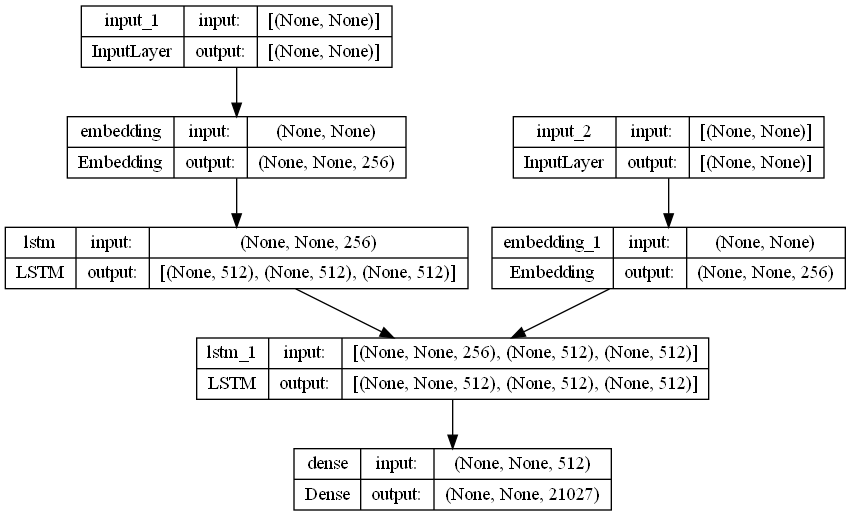

In [34]:

from tensorflow import keras

# Plot the model architecture
keras.utils.plot_model(model, to_file='LSTM_model_architecture.png', show_shapes=True)

# Model Fitting

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [36]:
hin_target_train = hin_train[:,1:]
hin_target_train = np.expand_dims(hin_target_train, axis=-1)

hin_target_val = hin_val[:,1:]
hin_target_val = np.expand_dims(hin_target_val, axis=-1)

hin_target_test = hin_test[:,1:]
hin_target_test = np.expand_dims(hin_target_test, axis=-1)

In [37]:
model.fit([eng_train, hin_train[:,:-1]], hin_target_train,
          batch_size=64,
          epochs=100,
          validation_data=([eng_val, hin_val[:,:-1]], hin_target_val),
         callbacks=[early_stopping])

Epoch 1/100


437/437 [==============================] - 331s 749ms/step - loss: 2.1243 - accuracy: 0.7244 - val_loss: 1.8802 - val_accuracy: 0.7414
Epoch 2/100
437/437 [==============================] - 327s 748ms/step - loss: 1.8402 - accuracy: 0.7415 - val_loss: 1.8250 - val_accuracy: 0.7416
Epoch 3/100
437/437 [==============================] - 326s 747ms/step - loss: 1.7789 - accuracy: 0.7451 - val_loss: 1.7907 - val_accuracy: 0.7441
Epoch 4/100
437/437 [==============================] - 326s 746ms/step - loss: 1.7313 - accuracy: 0.7493 - val_loss: 1.7200 - val_accuracy: 0.7531
Epoch 5/100
437/437 [==============================] - 327s 748ms/step - loss: 1.6915 - accuracy: 0.7539 - val_loss: 1.7316 - val_accuracy: 0.7521
Epoch 6/100
437/437 [==============================] - 325s 744ms/step - loss: 1.6625 - accuracy: 0.7574 - val_loss: 1.6842 - val_accuracy: 0.7545
Epoch 7/100
437/437 [==============================] - 327s 749ms/step - loss: 1.6304 - accuracy: 0.7614 - val_loss:

In [38]:
model.save('FinalLSTMwithMetrics.keras')

In [39]:
train_loss, train_accuracy = model.evaluate([eng_train, hin_train[:, :-1]], hin_target_train)
print('Training Accuracy: ', train_accuracy)


val_loss, val_accuracy = model.evaluate([eng_val, hin_val[:, :-1]], hin_target_val)
print('Validation Accuracy: ', val_accuracy)


test_loss, test_accuracy = model.evaluate([eng_test, hin_test[:, :-1]], hin_target_test)
print('Test Accuracy: ', test_accuracy)

873/873 [==============================] - 133s 153ms/step - loss: 1.2068 - accuracy: 0.7953
Training Accuracy:  0.7952578663825989
251/251 [==============================] - 37s 149ms/step - loss: 1.5074 - accuracy: 0.7810
Validation Accuracy:  0.7810186147689819
124/124 [==============================] - 18s 149ms/step - loss: 1.5159 - accuracy: 0.7799
Test Accuracy:  0.7798789143562317


# Inference Model

In [40]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

decoder_states = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states)

In [41]:


def decode_sequence(input_seq, encoder_model, decoder_model, hin_tokenizer, max_decoder_seq_length):
    start_token_index = hin_tokenizer.word_index.get('<START>', None)
    end_token_index = hin_tokenizer.word_index.get('<END>', None)

    if start_token_index is None or end_token_index is None:
        raise ValueError("Start or end token not found in tokenizer word index.")

    reverse_target_char_index = dict((i, word) for word, i in hin_tokenizer.word_index.items())

    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token_index

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] +  states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_char_index.get(sampled_token_index, '')

        if sampled_word == '<END>' or len(decoded_sentence.split()) >= max_decoder_seq_length:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

            
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

            states_value = [h, c]

    return decoded_sentence.strip()


In [42]:
input_sentence = "which is all about abraham to bethlehem"

input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_length_eng, padding='post')


translated_sentence = decode_sequence(input_seq, encoder_model, decoder_model, hin_tokenizer, max_length_hin)
print("Translated sentence:", translated_sentence)

1/1 [==============================] - 0s 21ms/step
Translated sentence: जो कि एक बहुत से अधिक अलग हो


In [43]:
input_sentence = "this world is full of wonders and miracles"


input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_length_eng, padding='post')


translated_sentence = decode_sequence(input_seq, encoder_model, decoder_model, hin_tokenizer, max_length_hin)
print("Translated sentence:", translated_sentence)

1/1 [==============================] - 0s 15ms/step
Translated sentence: ये हमारे लिए एक और अधिक अलग अलग अलग हैं


In [44]:
input_sentence = "close your eyes"

input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_length_eng, padding='post')

translated_sentence = decode_sequence(input_seq, encoder_model, decoder_model, hin_tokenizer, max_length_hin)
print("Translated sentence:", translated_sentence)

1/1 [==============================] - 0s 21ms/step
Translated sentence: अपने अपने बच्चों को अपने लिए


In [45]:
input_sentence = "hello how are you"

input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_length_eng, padding='post')

translated_sentence = decode_sequence(input_seq, encoder_model, decoder_model, hin_tokenizer, max_length_hin)
print("Translated sentence:", translated_sentence)

1/1 [==============================] - 0s 23ms/step
Translated sentence: क्या आप क्या कर रहे हैं


In [46]:
reference = [["नमस्ते", "आप", "कैसे", "हैं"]]
candidate = translated_sentence.split()

score = sentence_bleu(reference, candidate)
print(f"BLEU score: {score}")

BLEU score: 1.384292958842266e-231


C:\Users\sidac\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\sidac\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\sidac\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

# Evaluation

In [47]:
from evaluate import load
import numpy as np

metric_bleu = load("sacrebleu")
metric_meteor = load("meteor")
metric_ter = load("ter")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sidac\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sidac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sidac\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [48]:
import random

def evaluate_model(model, sources, raw_dataset):

    actual, predicted = [], []
    for i, source in enumerate(sources):
        source = source.reshape((1, source.shape[0]))
        translation = decode_sequence(source, encoder_model, decoder_model, hin_tokenizer, max_length_hin)
        actual.append([raw_dataset.iloc[i]])
        predicted.append(translation)
    
    
    print(predicted)
    print(actual)
    
    bleu_result = metric_bleu.compute(predictions=predicted, references=actual)
    bleu_score = bleu_result["score"]
    print('BLEU score:', bleu_score)

    meteor_result = metric_meteor.compute(predictions=predicted, references=actual)
    meteor_score = meteor_result["meteor"]
    print('METEOR score:', meteor_score)

    ter_result = metric_ter.compute(predictions=predicted, references=actual)
    ter_score = ter_result["score"]
    print('ter score:', ter_score)

    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    print('BLEU: %f' % corpus_bleu(actual, predicted))




In [51]:
evaluate_model(model, eng_test, hin_test_copy)

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 27ms/step
['और ये एक छोटा सा', 'उन्हें अपने बच्चों को भी नहीं', 'अब आप एक से एक बहुत ही उदाहरण हैं', 'और एक बहुत बड़ी दो साल', 'ये एक साल पहले से था', 'और लोगों को अलग करने में', 'एक छोटी सालों में एक व्यक्ति', 'क्योंकि एक दिन में एक और दो साल की', 'एक तरह से जो कि एक साथ में एक साथ', 'ये एक ही है जो हम बच्चों को आगे की तरह से कुछ ही नहीं है', 'या फिर भी एक ही', 'और हम सब से देखते हैं', 'वे अपने बच्चों को इस्तेमाल करना होगा', 'लेकिन ये एक ही और अधिक ही है', 'तालियाँ', 'वह एक ही था जो कि वो एक बार', 'एक बहुत ही लोग एक बहुत ही लोग हैं', 'यह एक ही था जो कि एक बार एक बार', 'जैसे आप देख सकते हैं', 'मैं आपको आपको बताना चाहता हूँ कि', 'जहाँ तक कि उन्हें कभी भी नहीं है', 'और यह एक बहुत ही विचार है', 'अगर अगर हम किसी के साथ एक साथ ले कर रहे हैं', 'हम इसे देखते हैं', 'और मैं आपको बताना चाहता हूँ कि आप इस तरह से कुछ भी', 'जो कि एक व्यक्ति का था जो कि एक बार', 'लेकिन यह सब बहुत ही है जो भी नहीं है', 'हमारे देश और अन्य और अधिक प्रतिशत', 'वह एक बार', 'जैसे क

BLEU score: 1.2297077124979217
METEOR score: 0.10194678499219767
ter score: 98.69319410547128
BLEU-1: 0.485335
BLEU-2: 0.332806
BLEU-3: 0.237936
BLEU-4: 0.171991
BLEU: 0.171991


In [54]:
df_train[0:5]

source                                   english_sentence  \
44855    ted  thankfully baby was out mother and child survived   
23094    ted             and that is a real fantastic bulls eye   
55944    ted  and watch them five times because they are so ...   
7125     ted            maybe how about i take my digital world   
75634    ted  for a long time india was this country of poverty   

                                          hindi_sentence  
44855  <START> शुक्र है शिशु बहार आ गया जच्चाबच्चा दो...  
23094               <START> यह एक विलक्षण दृश्य है <END>  
55944  <START> और उसे पांच बार देखेंगे क्यूंकि कि वो ...  
7125      <START> “क्यों न मैं डिजिट्ल दुनिया लेकर <END>  
75634  <START> एक लम्बे समय तक भारत अभावों का देश था ...

In [56]:
input_sentence = "thankfully baby was out mother and child survived"

input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_length_eng, padding='post')

translated_sentence = decode_sequence(input_seq, encoder_model, decoder_model, hin_tokenizer, max_length_hin)
print("Translated sentence:", translated_sentence)

1/1 [==============================] - 0s 27ms/step
Translated sentence: उस व्यक्ति को लेकर जो उनके लिए और उनके लिए


In [57]:
input_sentence = "and that is a real fantastic bulls eye"

input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_length_eng, padding='post')

translated_sentence = decode_sequence(input_seq, encoder_model, decoder_model, hin_tokenizer, max_length_hin)
print("Translated sentence:", translated_sentence)

1/1 [==============================] - 0s 25ms/step
Translated sentence: और ये एक बहुत बड़ा है


In [58]:
input_sentence = "maybe how about i take my digital world"

input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_length_eng, padding='post')

translated_sentence = decode_sequence(input_seq, encoder_model, decoder_model, hin_tokenizer, max_length_hin)
print("Translated sentence:", translated_sentence)

1/1 [==============================] - 0s 36ms/step
Translated sentence: जो मुझे लगता है कि मैं एक बार में


In [59]:
df_test[0:5]

source                                   english_sentence  \
27094     ted                                and that is tragedy   
49436     ted                               before they get made   
58528     ted  now a lot of you are probably familiar with de...   
21747     ted           and that is four percent of the universe   
109262    ted                     it was designed some years ago   

                                           hindi_sentence  
27094                      <START> और वह हैदुर्घटना <END>  
49436                   <START> इससे पहले कि वह बने <END>  
58528   <START> आप में से बहुत शायद देब रॉय के साथ परि...  
21747   <START> और उसकी मात्रा ब्रह्माण्ड मे सिर्फ प्र...  
109262          <START> यह लगभग साल पहले बनाई गई थी <END>

In [60]:
input_sentence = "and that is tragedy"

input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_length_eng, padding='post')

translated_sentence = decode_sequence(input_seq, encoder_model, decoder_model, hin_tokenizer, max_length_hin)
print("Translated sentence:", translated_sentence)

1/1 [==============================] - 0s 25ms/step
Translated sentence: और ये एक छोटा सा


In [61]:
input_sentence = "before they get made"

input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_length_eng, padding='post')

translated_sentence = decode_sequence(input_seq, encoder_model, decoder_model, hin_tokenizer, max_length_hin)
print("Translated sentence:", translated_sentence)

1/1 [==============================] - 0s 25ms/step
Translated sentence: उन्हें अपने बच्चों को भी नहीं


In [62]:
input_sentence = "and that is four percent of the universe"

input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_length_eng, padding='post')

translated_sentence = decode_sequence(input_seq, encoder_model, decoder_model, hin_tokenizer, max_length_hin)
print("Translated sentence:", translated_sentence)

1/1 [==============================] - 0s 27ms/step
Translated sentence: और एक बहुत बड़ी दो साल


In [63]:
evaluate_model(model, eng_val, hin_val_copy)

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 31ms/step
['मुझे एक से मुझे था', 'है', 'ये एक ही अलग अलग अलग अलग अलग अलग अलग होती हैं', 'और जब मैं एक बड़ी प्रयोग के बारे में', 'जो कि हमारी दुनिया को कैसे कुछ करने में', 'आप एक बार दो साल से एक बार एक बार ले सकते हैं', 'और अब हम जानते हैं कि हम इस बारे में बात नहीं है', 'और ये सच में है', 'यह एक बहुत ही है जो हम एक साथ में है', 'और हम एक और अधिक अलग अलग अलग अलग हैं', 'हमें हमें पता है कि हम बच्चों को एक चीज़ की तरह से अधिक नहीं है', 'जो हमें हमें हमें पता होगा कि हम बच्चों को', 'जब आप में से कुछ लोगों से ज्यादा ज्यादा लोग हैं', 'लेकिन ये सब बहुत ही है जो कि हमारी पास', 'मस्तिष्क के लिए', 'जो नहीं पता है', 'आप अपने लिए एक बहुत ही उदाहरण हैं', 'और वो एक बार में से', 'एक बार एक बार एक बार', 'लेकिन हमें पता था कि हम अपने बच्चों को भी नहीं करेंगे', 'वे सभी को', 'तालियाँ', 'और जब आप देखते हैं', 'एक एक बड़ी चुनौती', 'मुझे लगता है कि हमें एक और अधिक लोग हैं जो हम जानते हैं', 'और अगर आप एक बार देखें तो हम एक ही साल की', 'यह एक और दो और दो अलग अलग अलग ह

BLEU score: 1.2623726062447458
METEOR score: 0.10357889140663265
ter score: 98.0265666224398
BLEU-1: 0.482590
BLEU-2: 0.329938
BLEU-3: 0.235637
BLEU-4: 0.170166
BLEU: 0.170166
